In [1]:
%load_ext autoreload
%autoreload 2
# General imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.lines import Line2D
import sys
import os
import pandas as pd
import yaml
from copy import deepcopy
from cProfile import Profile
import networkx as nx
# picture path
PICS = '../pics/'
# Module imports
sys.path.append("../")
from contagion import Contagion, config
from contagion.config import _baseconfig
import seaborn as sns
import datetime
import pyabc
import wget
import scipy.stats


Bad key "text.kerning_factor" on line 4 in
/scratch4/chaack/software/miniconda3/envs/contagion/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
def mod_df(df, colname):
    df_de = df.loc[df["ISO 3166-1 Alpha 3-Codes"]=="DEU", ["Date", "Value"]]
    df_de["Date"] = pd.to_datetime(df_de["Date"], yearfirst=True)
    df_de = df_de.astype({"Value": "int"})
    df_de[colname] = df_de["Value"] # / 80E6 * 1E6
    df_de.set_index("Date", inplace=True)
    df_de.drop("Value", axis=1, inplace=True)
    return df_de
    

In [53]:
wget.download("https://data.humdata.org/hxlproxy/data/download/time_series_covid19_confirmed_global_narrow.csv?dest=data_edit&filter01=merge&merge-url01=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D1326629740%26single%3Dtrue%26output%3Dcsv&merge-keys01=%23country%2Bname&merge-tags01=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&filter02=merge&merge-url02=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D398158223%26single%3Dtrue%26output%3Dcsv&merge-keys02=%23adm1%2Bname&merge-tags02=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&merge-replace02=on&merge-overwrite02=on&filter03=explode&explode-header-att03=date&explode-value-att03=value&filter04=rename&rename-oldtag04=%23affected%2Bdate&rename-newtag04=%23date&rename-header04=Date&filter05=rename&rename-oldtag05=%23affected%2Bvalue&rename-newtag05=%23affected%2Binfected%2Bvalue%2Bnum&rename-header05=Value&filter06=clean&clean-date-tags06=%23date&filter07=sort&sort-tags07=%23date&sort-reverse07=on&filter08=sort&sort-tags08=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv",
             "time_series_covid19_confirmed_global_narrow.csv")
wget.download("https://data.humdata.org/hxlproxy/data/download/time_series_covid19_deaths_global_narrow.csv?dest=data_edit&filter01=merge&merge-url01=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D1326629740%26single%3Dtrue%26output%3Dcsv&merge-keys01=%23country%2Bname&merge-tags01=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&filter02=merge&merge-url02=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D398158223%26single%3Dtrue%26output%3Dcsv&merge-keys02=%23adm1%2Bname&merge-tags02=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&merge-replace02=on&merge-overwrite02=on&filter03=explode&explode-header-att03=date&explode-value-att03=value&filter04=rename&rename-oldtag04=%23affected%2Bdate&rename-newtag04=%23date&rename-header04=Date&filter05=rename&rename-oldtag05=%23affected%2Bvalue&rename-newtag05=%23affected%2Binfected%2Bvalue%2Bnum&rename-header05=Value&filter06=clean&clean-date-tags06=%23date&filter07=sort&sort-tags07=%23date&sort-reverse07=on&filter08=sort&sort-tags08=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv",
              "time_series_covid19_deaths_global_narrow.csv")
wget.download("https://data.humdata.org/hxlproxy/data/download/time_series_covid19_recovered_global_narrow.csv?dest=data_edit&filter01=merge&merge-url01=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D1326629740%26single%3Dtrue%26output%3Dcsv&merge-keys01=%23country%2Bname&merge-tags01=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&filter02=merge&merge-url02=https%3A%2F%2Fdocs.google.com%2Fspreadsheets%2Fd%2Fe%2F2PACX-1vTglKQRXpkKSErDiWG6ycqEth32MY0reMuVGhaslImLjfuLU0EUgyyu2e-3vKDArjqGX7dXEBV8FJ4f%2Fpub%3Fgid%3D398158223%26single%3Dtrue%26output%3Dcsv&merge-keys02=%23adm1%2Bname&merge-tags02=%23country%2Bcode%2C%23region%2Bmain%2Bcode%2C%23region%2Bsub%2Bcode%2C%23region%2Bintermediate%2Bcode&merge-replace02=on&merge-overwrite02=on&filter03=explode&explode-header-att03=date&explode-value-att03=value&filter04=rename&rename-oldtag04=%23affected%2Bdate&rename-newtag04=%23date&rename-header04=Date&filter05=rename&rename-oldtag05=%23affected%2Bvalue&rename-newtag05=%23affected%2Binfected%2Bvalue%2Bnum&rename-header05=Value&filter06=clean&clean-date-tags06=%23date&filter07=sort&sort-tags07=%23date&sort-reverse07=on&filter08=sort&sort-tags08=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv",
              "time_series_covid19_recovered_global_narrow.csv")
wget.download("https://covid.ourworldindata.org/data/owid-covid-data.csv")

'time_series_covid19_recovered_global_narrow.csv'

In [3]:
df_rec = mod_df(pd.read_csv("time_series_covid19_recovered_global_narrow.csv"), "recovered")
df_all = pd.read_csv("owid-covid-data.csv")
df_rec = mod_df(pd.read_csv("time_series_covid19_recovered_global_narrow.csv"), "recovered")
df_ger = pd.DataFrame(df_all[df_all["iso_code"] == "DEU"], copy=True)
df_ger["Date"] = pd.to_datetime(df_ger["date"], yearfirst=True)
df_ger.set_index("Date", inplace=True)
df_ger = df_ger.join(df_rec["recovered"])

[]

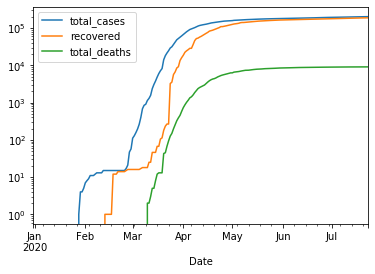

In [4]:
df_ger = df_ger.loc[:, ["total_cases", "recovered", "total_deaths"]]
df_ger.to_csv("data_germany.csv")
df_ger.plot()
plt.semilogy()


In [74]:
df_ger.index[-1]

Timestamp('2020-07-23 00:00:00')

In [23]:
pd.to_datetime('2020-02-24') - pd.to_datetime('2020-05-11')

Timedelta('-77 days +00:00:00')

In [98]:
full = False
soft_ld = True
data = pd.read_csv("data_germany.csv")
data["Date"] = pd.to_datetime(data['Date'])
if full:
    data = data.set_index("Date").loc[pd.to_datetime('2020-02-24'):]
else:
    data = data.set_index("Date").loc[pd.to_datetime('2020-02-24'):pd.to_datetime('2020-05-11')]
fields = ["is_recovered", "is_infected_total", "is_dead"]
#data = {field: np.asarray(contagion.statistics[field]) for field in fields}
data = {
        "is_recovered": data["recovered"]/80E6*1E5,
        "is_infected_total": data["total_cases"]/80E6*1E5,
        "is_dead": data["total_deaths"]/80E6*1E5
    }

In [76]:
print(pd.to_datetime('2020-02-24') + datetime.timedelta(days=25))

2020-03-20 00:00:00


In [102]:
my_config = yaml.unsafe_load(open("conf1_config.yaml"))

infect_pdf = scipy.stats.gamma(
    2.08,
    scale=1.56,
    )

my_config["measures"]["test true positive rate"] = 1
my_config["infection"]["will have symptoms prob pdf"] = {
    "class": "Delta",
    "mean": 0.5,
}
my_config["infection"]["infection probability pdf"] = {
        "class": "Gamma",
        "scaling": (infect_pdf.ppf(0.99))*0.0287,
        "mean":  infect_pdf.mean(),
        "sd":  infect_pdf.std()
}
my_config['infection']["hospitalization probability pdf"] = {
    'mean':  0.1,
    "class": "Delta"
}

my_config['infection']["hospitalization duration pdf"] = {
    'mean':  10,
    'sd':  5,
    "class": "Gamma"
}

my_config['infection']["mortality prob pdf"] = {
    'mean':  0.1,
    "class": "Delta"
}


my_config["infection"]["infectious duration pdf"] = {
    "mean": np.round(infect_pdf.ppf(0.99)),
    "class": "Delta"
}

my_config["infection"]["latency duration pdf"] = {
    #"mean": -cpp_config["Infectivity"]["mu"],
    #"class": "Delta"
    "upper": np.ceil(2.42),
    "lower": np.floor(2.42),
    "class": "Uniform"
}
ppl_met_per_day_pdf = scipy.stats.gamma(2, scale=10/2)
my_config["population"]["social circle interactions pdf"] = {
        "class": "Gamma",
        "mean": ppl_met_per_day_pdf.mean(),
        "sd": ppl_met_per_day_pdf.std(),
        "upper": np.inf
}
my_config["infection"]["incubation duration pdf"]["mean"] = 10
my_config["infection"]["incubation duration pdf"]["sd"] = 5
my_config["infection"]["incubation duration pdf"]["as_dtype"] = np.int
my_config["measures"]["backtrack length"] = 5
my_config["measures"]["track uninfected"] = True
my_config["measures"]["quarantine"] = True
my_config["measures"]["report symptomatic"] = True
my_config["measures"]["quarantine duration"] = 14
my_config["measures"]["testing"] = True
my_config["measures"]["time until test"] = 1
my_config["measures"]["time until result"] = 3
my_config["measures"]["time until second test"] = 0
my_config["measures"]["time until second test result"] = 0
my_config["measures"]["test true positive rate"] = 1.0
my_config["measures"]["test false positive rate"] = 0
my_config["measures"]["test threshold"] = 0.01
my_config["measures"]["app fraction"] = 1
my_config["measures"]["tracing efficiency"] = 0.5

my_config["scenario"]["class"] = "SocialDistancing"
my_config["scenario"]["t_steps"] = [0, 50]
my_config["scenario"]["contact_rate_scalings"] = [1, 0.2]
my_config["scenario"]["n_contacts_per_day_baseline"] = 10

yaml.dump(my_config, open("fit_germany_conf.yaml", "w"))




In [103]:
def model(parameters):
    infect_pdf = scipy.stats.gamma(
            2.08,
            scale=1.56,
        )
    this_config = dict(_baseconfig)
    this_config.update(my_config)
    this_config['population']['population size'] = 100000

    ppl_met_per_day_pdf = scipy.stats.gamma(2, scale=parameters["soc circ mean"]/2)
    this_config["population"]["social circle interactions pdf"] = {
        "class": "Gamma",
        "mean": ppl_met_per_day_pdf.mean(),
        "sd": ppl_met_per_day_pdf.std(),
        "upper": np.inf
    }


    this_config["infection"]["latency duration pdf"] = {
        "upper": np.floor(parameters["latency mean"]+1),
        "lower": np.floor(parameters["latency mean"]),
        "class": "Uniform"
    }

    this_config["infection"]["infection probability pdf"] = {
        "class": "Gamma",
        "scaling": (infect_pdf.ppf(0.99))*parameters["transmission prob"],
        "mean":  infect_pdf.mean(),
        "sd":  infect_pdf.std()
    }


    this_config['infection']["recovery time pdf"]['mean'] =  parameters["recovery dur mean"]        
    this_config['infection']["incubation duration pdf"]['mean'] =  parameters["incub dur mean"]
    this_config['infection']["incubation duration pdf"]['sd'] =  parameters["incub dur sd"]    
    this_config['infection']["hospitalization probability pdf"]["mean"] = parameters["hospit prob mean"]
    this_config['infection']["hospitalization duration pdf"]["mean"] = parameters["hospit dur mean"]
    this_config['infection']["hospitalization duration pdf"]["sd"] = parameters["hospit dur sd"]
    this_config["infection"]["mortality prob pdf"]["mean"] = parameters["mort mean"]
    this_config["infection"]["will have symptoms prob pdf"]["mean"] = parameters["symp prob mean"]


    this_config["scenario"]["class"] = "SocialDistancing"

    start_scaling = int(parameters["t_start_dist"])
    end_scaling = start_scaling + int(parameters["scaling_dur"])
    final_inf_per_day = parameters["int_per_day_dist"]

    slope = (parameters["soc circ mean"] - final_inf_per_day) / (start_scaling-end_scaling)
    offset =  parameters["soc circ mean"] - slope * start_scaling
    t_steps = np.arange(start_scaling)

    scalings =  list(slope*t_steps + offset)
    t_steps = list(t_steps)


    if soft_ld:
        start_soft = int(parameters["t_start_soft"])
        soft_inf_per_day = parameters["int_per_day_soft"]
        t_steps.append(start_soft)
        scalings.append(soft_inf_per_day)

    this_config["scenario"]["t_steps"] = t_steps
    this_config["scenario"]["contact_rate_scalings"] = scalings
    this_config["scenario"]["n_contacts_per_day_baseline"] = parameters["soc circ mean"]


    # this_config["scenario"]["class"] = "StandardScenario"

    this_config["population"]["re-use population"] = False
    this_config["population"]["store population"] = False
    this_config["measures"]["tracing efficiency"]
    contagion = Contagion(userconfig=this_config)
    contagion.sim()

    stats = pd.DataFrame(contagion.statistics)
    stats["is_infected_total"] = stats["is_index_case"]
   
    time_shift = int(parameters["timeshift"])
    if time_shift < 0:
        stats = stats.iloc[-time_shift:].reset_index()
    else:            
        zero_rows = pd.DataFrame({col: np.zeros(time_shift) for col in stats.columns})
        stats = pd.concat([zero_rows, stats]).reset_index()
    return stats.iloc[:len(data["is_recovered"])]
    

In [60]:
my_config["general"]["random state seed"] = 10
contagion = Contagion(my_config)
contagion.sim()

In [61]:
stats = pd.DataFrame(contagion.statistics)

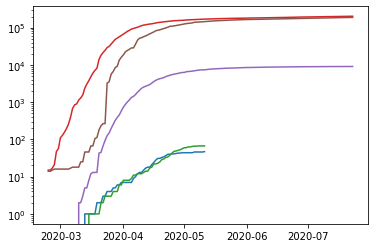

In [62]:
taxis = pd.date_range('2020-02-24', '2020-05-11', freq="d")
plt.plot(taxis, stats["is_index_case"].values[:78])
plt.plot(taxis, stats["is_dead"].values[:78])
plt.plot(taxis, stats["is_recovered"].values[:78])
plt.semilogy()

plt.plot(data["is_infected_total"])
plt.plot(data["is_dead"])
plt.plot(data["is_recovered"])


In [21]:
t_start_ld = 19
my_config["scenario"]["class"] = "SocialDistancing"
my_config["scenario"]["t_steps"] = [0, t_start_ld, t_start_ld+4, t_start_ld+10, t_start_ld+20, t_start_ld+20 + 26, t_start_ld+20 + 26+28]
my_config["scenario"]["contact_rate_scalings"] = [6./int_rate, 5./int_rate,  2.5/int_rate, 1/int_rate, 0.6/int_rate, 6/int_rate, 1]

my_config["measures"]["tracked fraction"] = 1.0
my_config["infection"]["will have symptoms prob pdf"]["mean"] = 0.3
my_config["infection"]["will have symptoms prob pdf"]["sd"] = 0.01

In [22]:
#yaml.dump(my_config, open("fit_germany_conf.yaml", "w"))

In [ ]:
db_path = "sqlite:///" + os.path.join(os.environ["HOME"], "abc_ger.db")
h_loaded = pyabc.History(db_path)

In [105]:
h_loaded.max_t

3

In [79]:
#sorted_pop = h_loaded.get_population_extended().sort_values("distance")
bfs = [{par_name[4:]: sorted_pop.iloc[i][par_name].item() for par_name in sorted_pop.iloc[i].index if "par" in par_name} for i in range(h_loaded.max_t)]

sim_datas = []
for i in range(5):  
    pars = bfs[i]
    sim_datas.append(model(pars))


IndexError: single positional indexer is out-of-bounds

In [97]:
colors = sns.color_palette("colorblind", 3)
taxis = pd.date_range('2020-02-24', '2020-03-20', freq="d")
plt.figure(figsize=(15, 5))
for sim_data in sim_datas:
    #conf = deepcopy(conf)
    #yaml.dump(conf, open("par_set_{}.yaml".format(i), "w"))
    for field, col in zip(fields, colors):
        plt.plot(taxis, sim_data[field], color=col, alpha=0.4)
for field, col in zip(fields, colors):
    plt.plot(taxis, data[field].values, color=col, ls="--", label=field, lw=2)
    
"""
mean_sim, _ = model(par_modes)
for field, col in zip(fields, colors):
    plt.plot(mean_sim[field], color=col, ls="-", label=field, lw=3)
""" 

    
#plt.xlabel("Time [days]")
plt.ylabel("Counts")
plt.legend()
plt.semilogy()
plt.savefig(os.path.join(PICS, "fit_ger.png"), dpi=200)

NameError: name 'sim_datas' is not defined

<Figure size 1080x360 with 0 Axes>

'    \nplt.xlabel("Time [days]")\nplt.ylabel("Counts")\nplt.legend()\nplt.xlim(0, 150)\n'

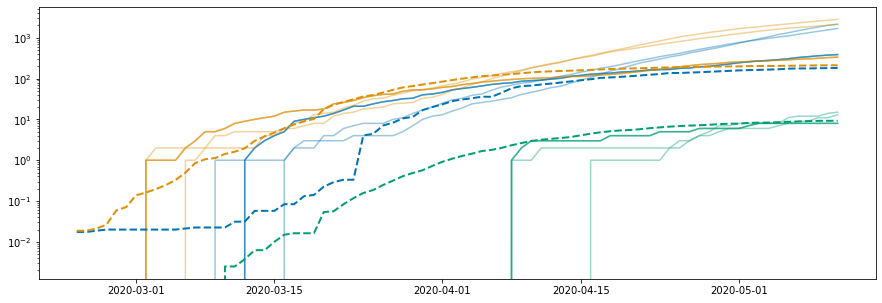

In [107]:
plt.figure(figsize=(15, 5))
colors = sns.color_palette("colorblind", 3)
df, w = h_loaded.get_distribution(m=0)
taxis = pd.date_range('2020-02-24', '2020-05-11', freq="d")
for i in range(5):
    pars = df.sample(1, weights=w).to_dict(orient="list")
    pars = {key: val[0] for key, val in pars.items()}
   
    #pars["recovery dur mean"] = 0.01
    sim_data = model(pars)
    for field, col in zip(fields, colors):
        plt.plot(taxis, sim_data[field], color=col, alpha=0.4)

for field, col in zip(fields, colors):
    plt.plot(taxis, data[field].values, color=col, ls="--", label=field, lw=2)
plt.semilogy()
"""
mean_sim, _ = model(par_modes)
for field, col in zip(fields, colors):
    plt.plot(mean_sim[field], color=col, ls="-", label=field, lw=3)
""" 

"""    
plt.xlabel("Time [days]")
plt.ylabel("Counts")
plt.legend()
plt.xlim(0, 150)
"""
#plt.semilogy()

In [65]:
h_loaded.id

27

Text(0, 0.5, 'Diff to prev. day')

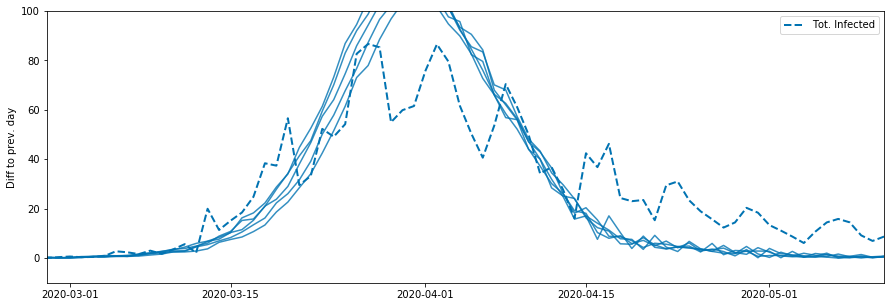

In [200]:
plt.figure(figsize=(15, 5))
for stats in sim_datas:
    plt.plot(taxis[1:], np.diff(stats["is_infected_total"][:len(taxis)]), color=colors[0], alpha=0.8)

plt.plot(taxis[1:], np.diff(data["is_infected_total"]), color=colors[0], ls="--", lw=2, label="Tot. Infected")

plt.ylim(-10, 100)
plt.xlim(datetime.date(2020, 2, 28), datetime.date(2020, 5, 11))
plt.legend()
plt.ylabel("Diff to prev. day")
#plt.savefig(os.path.join(PICS + "germany_diff.png"), dpi=150)

In [49]:
data["is_infected_total"]

Date
2020-02-24       0.2000
2020-02-25       0.2125
2020-02-26       0.3375
2020-02-27       0.5750
2020-02-28       0.6000
                ...    
2020-05-07    2117.8750
2020-05-08    2132.3500
2020-05-09    2141.5500
2020-05-10    2148.4875
2020-05-11    2157.2000
Name: tot. infected, Length: 78, dtype: float64

In [55]:
ts = pd.Series(stats["is_infected_total"].values, index=data["is_infected_total"].index)

[0.975784868222124, 0.9808921872764325, 0.984954534224757, 0.9879299449539755, 0.9897920907743035, 0.9905201901877827, 0.9901208266418793, 0.9885865910262763, 0.9859408526853521, 0.9822085470452201, 0.9774329910840357, 0.9714286749375056, 0.9642874143342748, 0.9560250840508153, 0.9466491337916711, 0.9361532472119298, 0.9245569325725187, 0.911906271844018, 0.8982831306893131, 0.8837832876947024]
[0.8690605177441779, 0.8818898266603012, 0.8942741288157635, 0.9061758513056735, 0.9175382851358506, 0.9283171496693486, 0.9384608514273531, 0.9479324075756251, 0.9566836783179457, 0.964677876445293, 0.9718842046786956, 0.9776428025764948, 0.9828259014354392, 0.9873751558384578, 0.9912380523661279, 0.994358458432781, 0.996676287148407, 0.9981394617565913, 0.9987034327833659, 0.9983472673771682]
[0.9656414587312943, 0.9706092074673721, 0.9744264061102778, 0.9770444066499573, 0.9784268442914341, 0.9785454968680414, 0.9773870858323161, 0.9749487199057356, 0.9712385651906734, 0.9662808965473868, 0.9

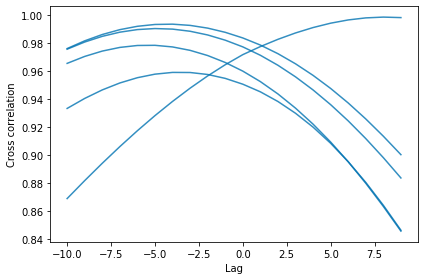

In [59]:
shifts = np.arange(-10, 10)

for stats in sim_datas:
    corrs = []
    for shift in shifts:
        ts = pd.Series(stats["is_infected_total"].values, index=data["is_infected_total"].index)
        corrs.append(ts.corr(data["is_infected_total"].shift(shift)))
    print(corrs)
    plt.plot(shifts, corrs, color=colors[0], alpha=0.8)
plt.ylabel("Cross correlation")
plt.xlabel("Lag")
plt.tight_layout()
#plt.savefig(os.path.join(PICS + "germany_deaths_infect_xcor.png"), dpi=150)

[]

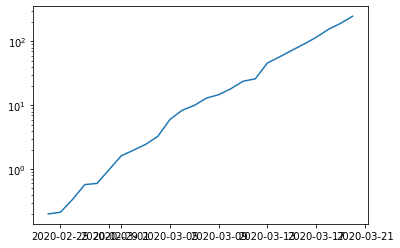

In [45]:
plt.plot(data["is_infected_total"].loc[pd.to_datetime('2020-02-24'):, ])
plt.semilogy()

In [9]:
contagion = Contagion(my_config)
prof = Profile()
contagion.sim()
stats = pd.DataFrame(contagion.statistics)

In [10]:
pd.to_datetime('2020-05-05')- pd.to_datetime('2020-02-20') - datetime.timedelta(22)

Timedelta('53 days 00:00:00')

In [11]:
pd.to_datetime('2020-03-20')- pd.to_datetime('2020-03-01') #- datetime.timedelta(22)

Timedelta('19 days 00:00:00')

In [23]:
df_de

,tot. infected,deaths,recovered
Date,,,
2020-01-22,0.0000,0.0000,0.00
2020-01-23,0.0000,0.0000,0.00
2020-01-24,0.0000,0.0000,0.00
2020-01-25,0.0000,0.0000,0.00
2020-01-26,0.0000,0.0000,0.00
...,...,...,...
2020-05-01,2050.9625,84.2000,1586.25
2020-05-02,2062.0875,85.1500,1612.50
2020-05-03,2070.8000,85.8250,1632.50


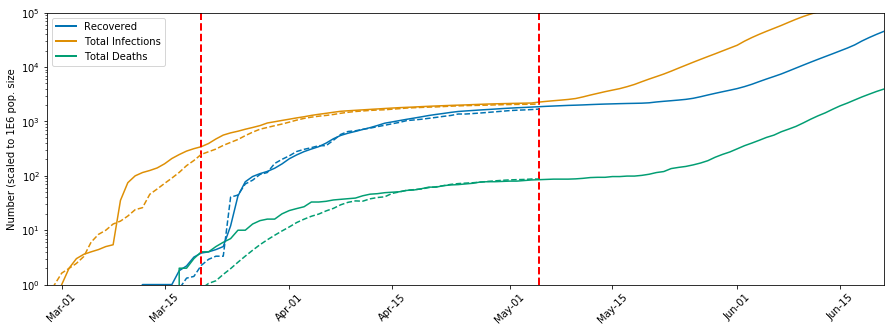

In [12]:
# LOOK AT PER DAY. CUMULATIVE SUMS UP ERRORS
plt.figure(figsize=(15, 5))
colors = sns.color_palette("colorblind", 3)
t_start = '2020-03-01'
id_rate = 0.2
taxis = pd.date_range(t_start, '2020-06-21', freq="d")



plt.plot(taxis, stats["is_recovered"][:len(taxis)]*id_rate, color=colors[0])
plt.plot(taxis, stats["is_infected"][:len(taxis)]*id_rate + stats["is_recovered"][:len(taxis)]*id_rate, color=colors[1])
plt.plot(taxis, stats["is_dead"][:len(taxis)], color=colors[2])

plt.axvline(pd.to_datetime(t_start)+datetime.timedelta(days=t_start_ld), color='r', linestyle='--', lw=2)
plt.axvline(pd.to_datetime(t_start)+datetime.timedelta(days=46+t_start_ld), color='r', linestyle='--', lw=2)
    



plt.plot(df_de.index, df_de["recovered"], color=colors[0], ls="--")
plt.plot(df_de.index, df_de["tot. infected"], color=colors[1], ls="--")
plt.plot(df_de.index, df_de["deaths"], color=colors[2], ls="--")
plt.xticks(rotation=45)

plt.semilogy()
date_form = DateFormatter("%b-%d")
plt.gca().xaxis.set_major_formatter(date_form)
plt.ylim(1, 1E5)
plt.xlim(datetime.date(2020, 2, 28), datetime.date(2020, 6, 21))

proxies = [
    Line2D([], [], lw=2, color=colors[0]),
    Line2D([], [], lw=2, color=colors[1]),
    Line2D([], [], lw=2, color=colors[2])]
labels = ["Recovered", "Total Infections", "Total Deaths"]
plt.legend(proxies, labels)
plt.ylabel("Number (scaled to 1E6 pop. size")
plt.savefig(os.path.join(PICS, "comp_ger_homogeneous.png"), dpi=150)


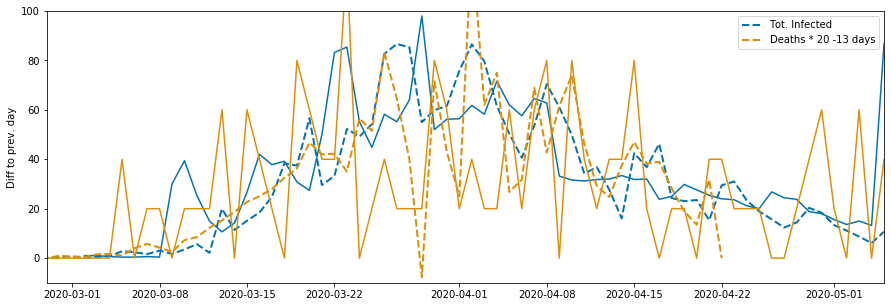

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(taxis[1:], np.diff(stats["is_infected"][:len(taxis)]+stats["is_recovered"][:len(taxis)])*id_rate, color=colors[0])

#plt.axvline(pd.to_datetime('2020-03-21'), color='r', linestyle='--', lw=2)

plt.plot(df_de.index[1:], np.diff(df_de["tot. infected"]), color=colors[0], ls="--", lw=2, label="Tot. Infected")
plt.plot(df_de.index[1:]-datetime.timedelta(13), np.diff(df_de["deaths"])*20, color=colors[1], ls="--", lw=2, label="Deaths * 20 -13 days")
plt.plot(taxis[1:]-datetime.timedelta(12), np.diff(stats["is_dead"][:len(taxis)])*20, color=colors[1], ls="-")
plt.ylim(-10, 100)
plt.xlim(datetime.date(2020, 2, 28), datetime.date(2020, 5, 5))
plt.legend()
plt.ylabel("Diff to prev. day")
plt.savefig(os.path.join(PICS + "germany_diff.png"), dpi=150)

In [263]:
stats["tot. infected"] = stats["is_infected"]+stats["is_recovered"]

In [1]:
shifts = np.arange(-15, 0)
for shift in shifts:
    plt.plot(shift, stats["tot. infected"].corr(stats["is_dead"].shift(shift)), "or")
    plt.plot(shift, df_de["tot. infected"].corr(df_de["deaths"].shift(shift)), "ok")
plt.ylabel("Cross correlation")
plt.xlabel("Lag")
plt.tight_layout()
plt.savefig(os.path.join(PICS + "germany_deaths_infect_xcor.png"), dpi=150)

NameError: name 'np' is not defined

0.9987258049699498

In [118]:
df_de["tot. infected"]

Date
2020-05-05    2087.5875
2020-05-04    2076.9000
2020-05-03    2070.8000
2020-05-02    2062.0875
2020-05-01    2050.9625
                ...    
2020-01-26       0.0000
2020-01-25       0.0000
2020-01-24       0.0000
2020-01-23       0.0000
2020-01-22       0.0000
Name: tot. infected, Length: 105, dtype: float64

In [10]:
df["ISO 3166-1 Alpha 3-Codes"].unique()

array(['#country+code', 'AFG', 'ALB', 'DZA', 'AND', 'AGO', 'ATG', 'ARG',
       'ARM', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR',
       'BEL', 'BLZ', 'BEN', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA', 'BRN',
       'BGR', 'BFA', 'MMR', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', nan, 'CAF',
       'TCD', 'CHL', 'CHN', 'HKG', 'MAC', 'COL', 'COM', 'COG', 'COD',
       'CRI', 'CIV', 'HRV', 'CUB', 'CYP', 'CZE', 'DNK', 'FRO', 'GRL',
       'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST',
       'SWZ', 'ETH', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'GLP', 'MTQ',
       'MYT', 'NCL', 'REU', 'BLM', 'SPM', 'MAF', 'GAB', 'GMB', 'GEO',
       'DEU', 'GHA', 'GRC', 'GRD', 'GTM', 'GIN', 'GNB', 'GUY', 'HTI',
       'VAT', 'HND', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL',
       'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KOR', 'RKS',
       'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LBR', 'LBY', 'LIE', 'LTU',
       'LUX', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MRT', 'MUS',
       'MEX'

In [85]:
a = [1, 2, 3]

fs = []

for aa in a:
    def _func():
        return aa
    fs.append(_func)

In [87]:
for f in fs:
    print(f())

3
3
3
